In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-21 23:50:50.535925: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 23:50:50.548481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761083450.563727  701693 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761083450.568133  701693 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 23:50:50.582889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

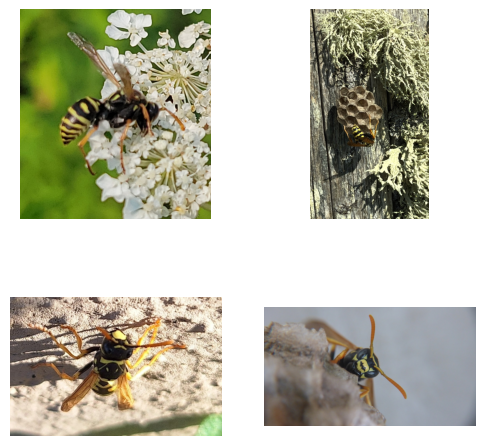

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 16

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)


#for layer in base_model.layers[:-10]:
#    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.2))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(127, activation='softmax'))



I0000 00:00:1761083454.740258  701693 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761083454.741351  701693 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46919 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 12,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761083477.981345  701947 service.cc:148] XLA service 0x718068017080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761083477.981367  701947 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761083477.981370  701947 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 23:51:18.804126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761083481.390899  701947 cuda_dnn.cc:529] Loaded cuDNN version 91200
2025-10-21 23:51:23.805422: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labe

  2/687 ━━━━━━━━━━━━━━━━━━━━ 1:02 91ms/step - accuracy: 0.0000e+00 - loss: 5.1230  

I0000 00:00:1761083497.220715  701947 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/687 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.0778 - loss: 4.4748

2025-10-21 23:52:32.802179: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-10-21 23:52:33.001510: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0962 - loss: 4.3329

2025-10-21 23:53:20.653688: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[6,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-10-21 23:53:20.789732: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[6,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati


Epoch 1: val_average_precision = 0.0334
687/687 ━━━━━━━━━━━━━━━━━━━━ 183s 208ms/step - accuracy: 0.1673 - loss: 3.7900 - val_accuracy: 0.0216 - val_loss: 6.1307 - val_average_precision: 0.0334 - learning_rate: 1.0000e-04
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3682 - loss: 2.4486

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 2: val_average_precision = 0.3832
687/687 ━━━━━━━━━━━━━━━━━━━━ 114s 165ms/step - accuracy: 0.3792 - loss: 2.3789 - val_accuracy: 0.3723 - val_loss: 2.4167 - val_average_precision: 0.3832 - learning_rate: 1.0000e-04
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5440 - loss: 1.6147
Epoch 3: val_average_precision = 0.4342
687/687 ━━━━━━━━━━━━━━━━━━━━ 109s 158ms/step - accuracy: 0.5438 - loss: 1.6191 - val_accuracy: 0.4120 - val_loss: 2.3190 - val_average_precision: 0.4342 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6735 - loss: 1.1031
Epoch 4: val_average_precision = 0.4370
687/687 ━━━━━━━━━━━━━━━━━━━━ 107s 156ms/step - accuracy: 0.6708 - loss: 1.1110 - val_accuracy: 0.4387 - val_loss: 2.3089 - val_average_precision: 0.4370 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7788 - loss: 0.7481
Epoch 5: val_average_precision = 0.4419
687/687 ━━━━━━━━━━━━━━━━━━━━ 107s 155ms/step - accuracy: 0.7623 - loss: 0.7861 - val_accuracy: 0.4380 - val_loss: 2.5422 - val_average_precision: 0.4419 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8339 - loss: 0.5306
Epoch 6: val_average_precision = 0.4272
687/687 ━━━━━━━━━━━━━━━━━━━━ 107s 156ms/step - accuracy: 0.8205 - loss: 0.5770 - val_accuracy: 0.4131 - val_loss: 2.8568 - val_average_precision: 0.4272 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8693 - loss: 0.4138
Epoch 7: val_average_precision = 0.4294
687/687 ━━━━━━━━━━━━━━━━━━━━ 105s 153ms/step - accuracy: 0.8656 - loss: 0.4281 - val_accuracy: 0.4277 - val_loss: 3.0791 - val_average_precision: 0.4294 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9004 - loss: 0.3172
Epoch 8: val_average_precision = 0.4334
687/687 ━━━━━━━━━━━━━━━━━━━━ 105s 153ms/step - accuracy: 0.8888 - loss: 0.3587 - val_accuracy: 0.4479 - val_loss: 2.9134 - val_average_precision: 0.4334 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9222 - loss: 0.2580
Epoch 9: val_average_precision = 0.4087
687/687 ━━━━━━━━━━━━━━━━━━━━ 104s 151ms/step - accuracy: 0.9120 - loss: 0.2891 - val_accuracy: 0.4123 - val_loss: 3.3326 - val_average_precision: 0.4087 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9363 - loss: 0.2101
Epoch 10: val_average_precision = 0.3993
687/687 ━━━━━━━━━━━━━━━━━━━━ 106s 154ms/step - accuracy: 0.9235 - loss: 0.2471 - val_accuracy: 0.3980 - val_loss: 3.5491 - val_average_precision: 0.3993 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9268 - loss: 0.2431
Epoch 11: val_average_precision = 0.4156
687/687 ━━━━━━━━━━━━━━━━━━━━ 105s 153ms/step - accuracy: 0.9233 - loss: 0.2624 - val_accuracy: 0.4299 - val_loss: 3.1842 - val_average_precision: 0.4156 - learning_rate: 1.0000e-04
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9450 - loss: 0.1838
Epoch 12: val_average_precision = 0.4129

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
687/687 ━━━━━━━━━━━━━━━━━━━━ 105s 153ms/step - accuracy: 0.9395 - loss: 0.2012 - val_accuracy: 0.4358 - val_loss: 3.4392 - val_average_precision: 0.4129 - learning_rate: 1.0000e-04
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9727 - loss: 0.0958
Epoch 13: val_average_precision = 0.4558
687/687 ━━━━━━━━━━━━━━━━━━━━ 104s 151ms/step - accuracy: 0.9766 - loss: 0.0790 - val_accuracy: 0.4831 - val_loss: 3.0167 - val_average_precision: 0.4558 - learning_rate: 5.0000e-05
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9934 - loss: 0.0252
Epoch 14: val_average_precision = 0.4584
687/687 ━━━━━━━━━━━━━━━━━━━━ 109s 158ms/step - accuracy: 0.9919 - loss: 0.0294 - val_accuracy: 0.4798 - val_loss: 3.0983 - val_average_precision: 0.4584 - learning_rate: 5.0000e-05
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9944 - loss: 0.0210
Epoch 15: val_average_precision = 0.4477
687/687 ━━━━━━━━━━━━━━━━━━━━ 115s 167ms/step - accuracy: 0.9914 - loss: 0.0298 - val_accuracy: 0.4729 - val_loss: 3.3777 - val_average_precision: 0.4477 - learning_rate: 5.0000e-05
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9878 - loss: 0.0364
Epoch 16: val_average_precision = 0.4166
687/687 ━━━━━━━━━━━━━━━━━━━━ 111s 162ms/step - accuracy: 0.9883 - loss: 0.0404 - val_accuracy: 0.4303 - val_loss: 3.7063 - val_average_precision: 0.4166 - learning_rate: 5.0000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


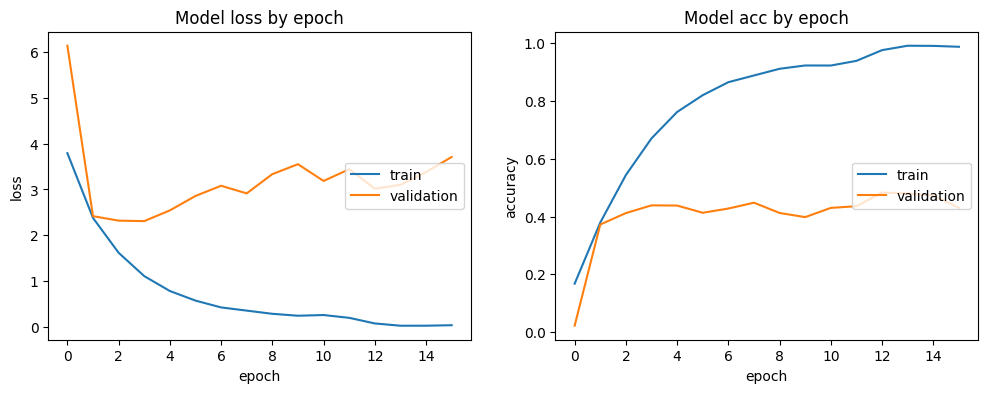

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp6.h5')